# Question Answering

In [1]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [2]:
## For our case, we will focus on building a QA system for the Electronics domain

from datasets import load_dataset
subjqa = load_dataset("subjqa", name = "electronics")

In [3]:
print(subjqa['train']["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


we can see that the answers are stored in a text field, while the starting character indices are provided in answer_start. To explore the dataset more easily, we’ll flatten these nested columns with the flatten() method and convert each split to a Pandas
DataFrame as follows:

In [4]:
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


Notice that the dataset is relatively small, with only 1,908 examples in total. This simulates a real-world scenario, since getting domain experts to label extractive QA datasets is labor-intensive and expensive.

In [5]:
dfs['train'].head()

,domain,nn_mod,nn_asp,query_mod,query_asp,q_reviews_id,question_subj_level,ques_subj_score,is_ques_subjective,review_id,id,title,context,question,answers.text,answers.answer_start,answers.answer_subj_level,answers.ans_subj_score,answers.is_ans_subjective
0,electronics,great,bass response,excellent,bass,0514ee34b672623dff659334a25b599b,5,0.50,False,882b1e2745a4779c8f17b3d4406b91c7,2543d296da9766d8d17d040ecc781699,B00001P4ZH,"I have had Koss headphones in the past, Pro 4A...",How is the bass?,[],[],[],[],[]
1,electronics,harsh,high,not strong,bass,7c46670208f7bf5497480fbdbb44561a,1,0.50,False,ce76793f036494eabe07b33a9a67288a,d476830bf9282e2b9033e2bb44bbb995,B00001P4ZH,To anyone who hasn't tried all the various typ...,Is this music song have a goo bass?,"[Bass is weak as expected, Bass is weak as exp...","[1302, 1302]","[1, 1]","[0.5083333, 0.5083333]","[True, True]"
2,electronics,neutral,sound,present,bass,8fbf26792c438aa83178c2d507af5d77,1,0.50,False,d040f2713caa2aff0ce95affb40e12c2,455575557886d6dfeea5aa19577e5de4,B00001P4ZH,I have had many sub-$100 headphones from $5 Pa...,How is the bass?,[The only fault in the sound is the bass],[650],[2],[0.6333333],[True]
3,electronics,muddy,bass,awesome,bass,9876fd06ed8f075fcad70d1e30e7e8be,1,0.50,False,043e7162df91f6ea916c790c8a6f6b22,6895a59b470d8feee0f39da6c53a92e5,B00001WRSJ,My sister's Bose headphones finally died and s...,How is the audio bass?,[the best of all of them],[1609],[1],[0.3],[False]
4,electronics,perfect,bass,incredible,sound,16506b53e2d4c2b6a65881d9462256c2,1,0.65,True,29ccd7e690050e2951be49289e915382,7a2173c502da97c5bd5950eae7cd7430,B00001WRSJ,Wow. Just wow. I'm a 22 yr old with a crazy ob...,Why do I have an incredible sound?,"[The sound is so crisp, crazy obsession with s...","[141, 38]","[1, 1]","[0.40833333, 0.40833333]","[False, False]"


There are quite a few columns in the subjQA, but the most interesting ones for building our QA system are shown below:

| Column Name | Description |
|:--------:|:--------:|
|  title   | The Amazon Standard Identification Number (ASIN) associated with each product |
|  question  | The Question    |
|  answers.text | The span of text in the review labeled by the annotator |
| answers.answer_start | The start character index of the answer span |
| context | The customer review |

In [6]:
qa_cols = ["title", "question", "answers.text", "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state = 7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


From these examples we can make a few observations. First, the questions are not grammatically correct, which is quite common in the FAQ sections of ecommerce websites. Second, an empty `answers.text` denotes **unanswerable** questions whose answers cannot be found in the review. Finally, we can use the start index and length of the answer span of text in the review that corresponds to the answer:

In [7]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

Next, let's get a fell for what types of questions are in the training set by counting the questions that begin with a few common starting words:

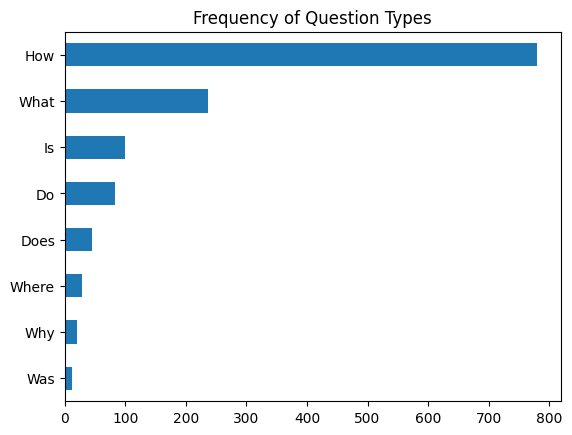

In [8]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs['train']["question"].str.startswith(q).value_counts()[True]

import matplotlib.pyplot as plt
%matplotlib inline
pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()    

We can see that questions beginning with `How`, `What`, `Is` are the most common ones, so lets have a look at some examples:

In [9]:
for question_type in ["How", "What", "Is"]:
    for question in (
        dfs['train'][dfs['train'].question.str.startswith(question_type)]
        .sample(n = 3, random_state = 42)['question']
    ):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


Now that we've exlpored our dataset a bit, lets dive into understanding how transformers can extract answers from text.

## Extracting Answers from Text 

The first thing we'll need from our QA system is to find a way to identify a potential answer as a span of text in a customer review. To do this, we'll need to understand how to:

- Frame the supervised learning probelm.
- Tokenize and encode text for QA tasks.
- Deal with long passages that exceed a model's maximum context size.

Let's start by taking a look at how to frame the problem.

### Span Classification

The most common way to extract answers from text is by framing the problem as a *span classification* task, where the start and end of the tokens of an answer span act as the labels that a model needs to predict.

Since our training set is relatively small, with only 1,295 examples,  a good strategy is to start with a language model that has already been fine-tuned on a large-scale QA dataset like SQuAD. In general, these models have strong reading comprehension capabilities and serve as a good baseline upon which to build a more accurate system. For extractive QA, we can actually start with a fine-tuned model since the structure of the labels remains the same accross datasets.

We'll use a fine-tuned `MiniLM` model since it is fast to train and will allow us to quickly iterate on the techniques that we'll be exploring.

#### Tokenizing text for QA

In [10]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer =  AutoTokenizer.from_pretrained(model_ckpt)

In [11]:
question = "How much music can this hold?"
context = "An MP3 is about 1 MB/minute, so about 6000 hours depending on file size."
inputs = tokenizer(question, context, return_tensors = "pt")

To understand how the tokenizer formats the inputs for QA tasks , lets decode the `input_ids` tensor:

In [12]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


For QA example, the inputs take the format:

    [CLS] question tokens [SEP] context tokens [SEP]

where the location of the first [SEP] token is determined by the `token_type_ids`. Now that our text is tokenized, we just need to instantiate the model with a QA head and run the inputs through the forward pass:    

In [13]:
import torch 
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

2025-06-02 13:36:02.957887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748851562.972634   52792 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748851562.976992   52792 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748851562.990312   52792 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748851562.990336   52792 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748851562.990337   52792 computation_placer.cc:177] computation placer alr

In [14]:
with torch.no_grad():
    outputs = model(**inputs)

print(outputs)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


Here we can see that we get a QuestionAnsweringModelOutput object as the output of the QA head. The QA head corresponds to a linear layer that takes the hidden states from the encoder and computes the logits for the start and end spans. To convert the outputs into an answer span, we first need to get the logits for the start and end tokens:

In [15]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [16]:
print(f"Input IDs Shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs Shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


To get the final answer, we can compute the argmax over the start and end token logits and then slice the span from the inputs.

In [17]:
start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits)
answer_span =  inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000


In transformers, all of these prepocessing and postprocessing steps are conveniently wrapped in a dedicated pipeline. We can instantiate the pipeline by passing tokenizer and fine-tuned model as follows:

In [18]:
from transformers import pipeline

pipe =  pipeline("question-answering",model = model, tokenizer = tokenizer)
pipe(question = question, context = context, topk = 3)

Device set to use cuda:0
/home/vjay/.pyenv/versions/3.11.12/lib/python3.11/site-packages/transformers/pipelines/question_answering.py:334: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.26516327261924744,
  'start': 38,
  'end': 48,
  'answer': '6000 hours'},
 {'score': 0.22082901000976562,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253418982028961,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In addition to the answer, the pipline returns the model's probability estimate in the score field (obtained by taking a `softmax` over the `logits`).

Sometimes, it is possible to have questions for which no answer is possible, like the empty `answers.answer_start` examples in `SubjQA`. In these cases, the model will assign a high start and end score to the [CLS] token, and the pipeline maps this output to an empty string:

In [19]:
pipe(question = "Why is there no data?",  context = context,
     handle_impossible_answer = True)

{'score': 0.9068416357040405, 'start': 0, 'end': 0, 'answer': ''}

### Dealing with long passages

One subtlety faced by reading comprehension models is that the context often contains more tokens than the maximum sequence length of the model (which is usually a few hundred tokens at most). 

The standard way to deal with this is to apply a *sliding window* across the inputs, where each window contains a passage of tokens that fit in the model's context.

In transformers, we can set `return _overflowing_tokens` =  `True` in the `tokenizer` to enable the *sliding window*. The size of the sliding window is controlled by `doc_stride`.

In [20]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"],
                              return_overflowing_tokens=True, max_length=100,
                              stride=25, truncation = True)

In [21]:
## Let's check number of tokens in each window:

for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens.")

Window #0 has 100 tokens.
Window #1 has 88 tokens.


In [22]:
## Lets see where they overlap

for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



Let's look at the other components we need to build an end-to-end QA pipeline.

## Using Haystack to Build a QA Pipeline

Modern QA systems are typically based on the **retriever-reader** architecture.

    Unstrucured Documents >> **Retriever** >> Document Postprocessing >> **Relevant documents** >> **Reader** >> Answer postprocessing

Retriever and Reader are both fed the question/query.    

To build our QA system, we'll use `Haystack library` developed by deepset. Haystack is based on the retriever-reader architecture, abstracts much of the complexity involved in building these systems, and integrates tightly with Tranformers.

In addition to the retriever and reader, there are two more components involved when building a QA pipeline with Haystack:

    - Document store: A document-oriented database that stores documents and metadata which are provided to the retriever at query time.
    - Pipeline: Comnbines all the components of a QA system to enable custom query flows, merging documents from multiple retrievers, and more.

 ### Initailizing a document store

 In Haystack, there are various document stores to choose from and each one can be paired with a dedicated set of retrievers. The compatibility of sparse (TF-IDF, BM25) and dense (Embedding, DPR) retrievers is shown for each of the available stores.

 |          | In memory | ElasticSearch | FAISS | Milvus |
 | -------- | --------- | ------------- | ----- | ------ |
 | TF-IDF | Yes | Yes | No | No |
 | BM25 | No | Yes | No | No |
 | Embedding | Yes | Yes | Yes| Yes|     

 We'll use **ElasticsearchDocument Store**, which is compatible with both retriever types. Elasticsearch is a search engine that is capable of handling a diverse range of data types, including textual, numerical, geospatial, structured, and unstructured.Its ability to store huge volumes of data and quickly filter it with full-text search features makes it especially well suited for developing QA systems.

In [23]:
from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore

document_store = ElasticsearchDocumentStore(
    host="localhost",
    port=9200,
    username="elastic",
    password="e9wYTA640ou8R3ObO4T8",
    scheme="https",             # important: matches curl
    verify_certs=False,         # because using self-signed TLS
    return_embedding=True
)

/home/vjay/.pyenv/versions/3.11.12/lib/python3.11/site-packages/elasticsearch/connection/http_urllib3.py:209: UserWarning: Connecting to https://localhost:9200 using SSL with verify_certs=False is insecure.
  warnings.warn(
/home/vjay/.pyenv/versions/3.11.12/lib/python3.11/site-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/vjay/.pyenv/versions/3.11.12/lib/python3.11/site-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/vjay/.pyenv/versions/3.11.12/lib/python3.11/site-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning

In [24]:
for split, df in dfs.items():
    docs = [{
        "content": row["context"],
        "meta": {
            "item_id": row["title"],
            "question_id": row["id"],
            "split": split
        }
    } for _, row in df.drop_duplicates(subset="context").iterrows()]
    
    document_store.write_documents(docs, index="document")

print(f"Loaded {document_store.get_document_count()} documents")


/home/vjay/.pyenv/versions/3.11.12/lib/python3.11/site-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/vjay/.pyenv/versions/3.11.12/lib/python3.11/site-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/vjay/.pyenv/versions/3.11.12/lib/python3.11/site-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/vjay/.p

Loaded 1615 documents


/home/vjay/.pyenv/versions/3.11.12/lib/python3.11/site-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Great, we've loaded our reviews into an index! To search the index we''ll need a retriever, so let's look at how we can initialize one for Elasticsearch.

### Initializing a Retriever

Let's start by using a sparse retriever based on `BM25` (short for "Best Match 25"). The BM23 score measures how much matched text is about a search query and improves on `TF-IDF` by saturating **TF** values quickly and normalizing the document length so that short documents are favored over long ones.


In [25]:
from haystack.nodes import BM25Retriever

bm_retriever = BM25Retriever(document_store = document_store)

For review-based QA systems like ours, it's important to restrict the queries to a single item because otherwise the retriever would source reviews about products that are not related to user's query.

By themselves, the **ASIN values** in our dataset are a bit cryptic, but we can decipher them with online tools like amazon ASIN or by simply appending the value of item_id to the www.amazon.com/dp/ URL. The following item ID corresponds to one of Amazon’s Fire tablets, so let’s use the retriever’s `retrieve()` method to ask if it’s any good for reading with:

In [26]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = bm_retriever.retrieve(
    query = query, top_k = 3, filters = {"item_id": [item_id], "split": ["train"]}
)

/home/vjay/.pyenv/versions/3.11.12/lib/python3.11/site-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Each element of `retrieved_docs` is a **Haystack Document** object that is used to represent documents and includes the retriever's query score along with other metadata.

In [27]:
print(retrieved_docs[0].to_dict())

{'content': 'This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my laptop, my phone and my iPod classic.  I love my iPod but watching movies on the plane with it can be challenging because it is so small. Laptops battery life is not as good as the Kindle.  So the Fire combines for me what I needed all three to do. So far so good.', 'content_type': 'text', 'score': 0.6857824513476455, 'meta': {'item_id': 'B0074BW614', 'question_id': '868e311275e26dbafe5af70774a300f3', 'split': 'train'}, 'id_hash_keys': ['content'], 'embedding': None, 'id': '252e83e25d52df7311d597dc89eef9f6'}


In addition to the document's text, we can see the score that Elasticsearch computed for its relevance to the query (large score imply a better match). Under the hood, Elasticsearch relies on (**Lucene**)[!https://lucene.apache.org] for indexing and search, so by default it uses Lucene's practical scoring function. In brief terms, it first filters the candidate documents by applying a Boolean test (does the document match the query?), and then applies a similarity test that's based on representing both the document and the query as vectors.

Now we need to extract answers from them. This is where the `reader` comes in, so lets load our MiniLM model in Haystack.

### Initializing a reader

In Haystack, there are two types of readers:

1. `FARMReader`: Based on deepset's *FARM* framework for fine-tuning anf deploying transformers. Compatible with models trained using Hugging Face transformers and can load models directly from Hugging Face Hub.

2. `TransformersReader`: Based on the QA pipeline from Hugging Face Transformers. Suitable for **running inference** only.

Since we will be fine-tuning the reader later in the chapter, we’ll use the `FARMReader`.

In [28]:
from haystack.nodes import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path = model_ckpt, progress_bar = False,
                    max_seq_len = max_seq_length, doc_stride = doc_stride,
                    return_no_answer = True)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
print(reader.predict_on_texts(question = question, texts = [context], top_k = 1))

{'query': 'How much music can this hold?', 'no_ans_gap': np.float32(12.648085), 'answers': [<Answer {'answer': '6000 hours', 'type': 'extractive', 'score': 0.5293067097663879, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.', 'offsets_in_document': [{'start': 38, 'end': 48}], 'offsets_in_context': [{'start': 38, 'end': 48}], 'document_ids': ['e344757014e804eff50faa3ecf1c9c75'], 'meta': {}}>]}


Great, the reader appears to be working as expected—so next, let’s tie together all our components using one of Haystack’s pipelines.

### Putting it all together

Haystack provides a Pipeline abstraction that allows us to combine retrievers, readers, and other components together as a graph that can be easily customized for each use case. There are also predefined pipelines analogous to those in Hugging Face Transformers, but specialized for QA systems. 

In [30]:
from haystack.pipelines import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader, bm_retriever)  ## It takes a single retriever-reader pair as its argument.

In [34]:
n_answers = 3

preds = pipe.run(
    query=query,
    params={
        "Retriever": {"top_k": 3, "filters": {"item_id": [item_id], "split": ["train"]}},
        "Reader": {"top_k": n_answers}
    }
)

print(f"Question: {preds['query']} \n")

for idx in range(n_answers):
    answer_obj = preds['answers'][idx]
    print(f"Answer {idx+1}: {answer_obj.answer}")
    print(f"Review snippet: ...{answer_obj.context}...")
    print("\n\n")


Question: Is it good for reading? 

Answer 1: it is great for reading books when no light is available
Review snippet: ...ecoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest good headphones t...



Answer 2: I mainly use it for book reading
Review snippet: ... is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my la...



Answer 3: 
Review snippet: ...None...





/home/vjay/.pyenv/versions/3.11.12/lib/python3.11/site-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Great, we now have an end-to-end QA system for Amazon product reviews!